In [1]:
import geopandas as gpd
import gmaps
import pandas as pd
from matplotlib import pyplot as plt
import shapely
from shapely.geometry import Point, Polygon, box
import numpy as np
import pickle

In [2]:
india_gdf = gpd.read_file('./india/IND_adm0.shp')
india_gdf

,ID_0,ISO,NAME_ENGLI,NAME_ISO,NAME_FAO,NAME_LOCAL,NAME_OBSOL,NAME_VARIA,NAME_NONLA,NAME_FRENC,...,CARICOM,EU,CAN,ACP,Landlocked,AOSIS,SIDS,Islands,LDC,geometry
0,105,IND,India,INDIA,India,Bharat,None,Bharat|Damão and Diu|Goa|Hindustan,None,Inde,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."


Mainland at polygon 756 


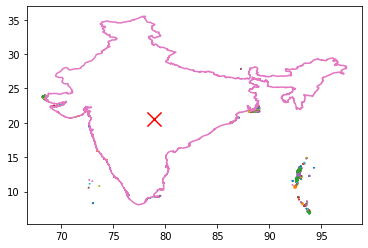

In [3]:
indCenter = Point(78.9629,20.5937) #get some centre point in mainland from net
for idx,i in enumerate(india_gdf['geometry'][0]):
    x,y = i.exterior.xy
    plt.plot(x,y)
    if indCenter.within(i):
        indPoly = np.array([(yi,xi) for xi,yi in zip(x,y)])
        print("Mainland at polygon {} ".format(idx))
plt.scatter([78.9629], [20.5937], c='r', marker='x', s=200)
plt.show()

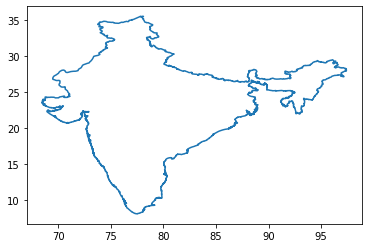

array([[35.42789459, 77.89956665],
       [35.42758942, 77.90296936],
       [35.42935944, 77.91018677],
       ...,
       [35.43195724, 77.88477325],
       [35.42887115, 77.8886261 ],
       [35.42789459, 77.89956665]])

In [4]:
plt.plot(indPoly[:,1],indPoly[:,0])
plt.show()
indPoly

In [5]:
pickle.dump(indPoly,open(".indPoly.pkl","wb"))

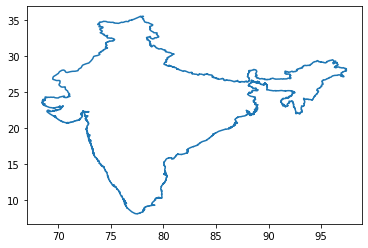

In [6]:
#see if map was read correctly
indPoly = pickle.load(open("indPoly.pkl","rb"))
indPoly = Polygon(np.flip(indPoly))
x,y = indPoly.exterior.xy
plt.plot(x,y)

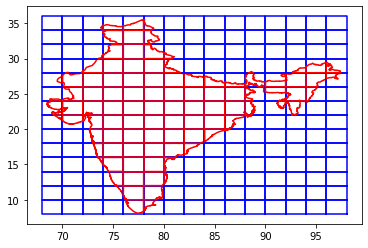

In [7]:
dim = 2
bounds = indPoly.bounds
xmin = int(bounds[0]//dim)
xmax = int(bounds[2]//dim)
ymin = int(bounds[1]//dim)
ymax = int(bounds[3]//dim)
for i in range(xmin,xmax+1):
    for j in range(ymin,ymax+1):
        b = box(i*dim,j*dim,(i+1)*dim,(j+1)*dim)
        g = indPoly.intersection(b)
        x,y = b.exterior.xy
        plt.plot(x,y,c='b')
        if g.is_empty:
            continue
        if type(g)==shapely.geometry.multipolygon.MultiPolygon:
            for ge in g.geoms:
                x,y = ge.exterior.xy
                plt.plot(x,y,c='r')
        else :
            x,y = g.exterior.xy
            plt.plot(x,y,c='r')
plt.show()

In [8]:
def partition(polygon, dim, merge_factor=0.1):
    bounds = polygon.bounds
    xmin = int(bounds[0] // dim)
    xmax = int(bounds[2] // dim)
    ymin = int(bounds[1] // dim)
    ymax = int(bounds[3] // dim)
    grid = 0
    res = []
    for i in range(xmin, xmax+1):
        for j in range(ymin, ymax+1):
            b = box(i*dim, j*dim, (i+1)*dim, (j+1)*dim)
            g = polygon.intersection(b)
            if g.is_empty:
                continue
            if type(g)==shapely.geometry.multipolygon.MultiPolygon:
                for ge in g.geoms:
                    res.append(ge)
                    grid += 1
            else:
                res.append(g)
                grid += 1
    return merge(res, merge_factor)

In [9]:
def merge(poly_list, mergeFactor=0.1):
    def combine(pidx, poly_list):
        p = poly_list[pidx]
        del poly_list[pidx]
        for idx,i in enumerate(poly_list):
            u = p.union(i)
            if p.intersects(i) and type(u)!=shapely.geometry.multipolygon.MultiPolygon:
                poly_list[idx] = u
                break
        return poly_list
    
    mn_limit = max(poly_list, key=lambda x:x.area).area * mergeFactor
    mn_poly = min(poly_list, key=lambda x:x.area)
    while(mn_poly.area<=mn_limit):
        poly_list = combine(poly_list.index(mn_poly), poly_list)
        mn_poly = min(poly_list, key=lambda x:x.area)
        
    result = {}
    for idx,i in enumerate(poly_list):
        x,y = i.exterior.xy
        result[idx] = np.array([(y,x) for x,y in zip(x,y)])
    return result

In [10]:
def plot_map(poly_grid):
    g_poly = []
    g_mark_loc = []
    g_mark_inf = []
    info_box_template = """
    <dl>
    <dd>{}</dd>
    </dl>
    """
    for k,v in poly_grid.items():
        g_poly.append(gmaps.Polygon(
                                    list(v),
                                    stroke_color='red',
                                    fill_color='blue'
                                    ))
        g_mark_loc.append((v[0][0],v[0][1]))
        g_mark_inf.append(info_box_template.format(k))
    fig = gmaps.figure(center=(78.9629,20.5937), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=g_poly))
    #fig.add_layer(gmaps.marker_layer(g_mark_loc, info_box_content=g_mark_inf))
    return fig

In [11]:
indPolyGrid = partition(indPoly,2,merge_factor=0.1)

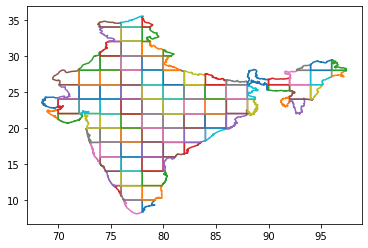

93

In [12]:
for i in indPolyGrid.values():
    plt.plot(i[:,1],i[:,0])
plt.show()
len(indPolyGrid)

In [13]:
plot_map(indPolyGrid)

Figure(layout=FigureLayout(height='420px'))

In [14]:
pickle.dump(indPolyGrid,open("indPolyGrid.pkl","wb"))